<a href="https://colab.research.google.com/github/dbenayoun/IASD/blob/main/ProjetIA/Copie_de_Adversarial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from random import random

cuda = torch.cuda.is_available()

## From adversarial examples to training robust models

In the previous notebooks, we focused on methods for solving the maximization problem over perturbations; that is, to finding the solution to the problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}

In this notebook, we will focus on training a robust classifier. More precisly, we aim at solving following minimization problem, namely Adversarial Training:
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{|S|} \sum_{x,y \in S} \max_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
The order of the min-max operations is important here.  Specially, the max is inside the minimization, meaning that the adversary (trying to maximize the loss) gets to "move" _second_.  We assume, essentially, that the adversary has full knowledge of the classifier parameters $\theta$, and that they get to specialize their attack to whatever parameters we have chosen in the outer minimization. The goal of the robust optimization formulation, therefore, is to ensure that the model cannot be attacked _even if_ the adversary has full knowledge of the model.  Of course, in practice we may want to make assumptions about the power of the adversary but it can be difficult to pin down a precise definition of what we mean by the "power" of the adversary, so extra care should be taken in evaluating models against possible "realistic" adversaries.

## Exercice 1
1. Train a robust classifier using Adversarial Training with a specific norm
2. Evaluate your classifier on natural and adversarial examples crafted with the norm of the training and other norms
3. Make an analysis and conclude

In [2]:
# load CIFAR10 dataset
def load_cifar(split, batch_size):
  train = True if split == 'train' else False
  dataset = datasets.CIFAR10("./docs", train=split, download=True, transform=transforms.ToTensor())
  return DataLoader(dataset, batch_size=batch_size, shuffle=train)

cifar10_classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

batch_size = 100
train_loader = load_cifar('train', batch_size)
test_loader = load_cifar('test', batch_size)



100%|██████████| 170M/170M [00:04<00:00, 42.3MB/s]


Extracting ./docs/cifar-10-python.tar.gz to ./docs
Files already downloaded and verified


In [3]:
class ConvModel(torch.nn.Module):

  def __init__(self):
    super(ConvModel, self).__init__()
    # First Convolutional Layer: Input channels = 3, Output channels = 32
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    # First Max Pooling Layer: Reduces each dimension by a factor of 2
    self.pool1 = nn.MaxPool2d(kernel_size=2)

    # Second Convolutional Layer: Input channels = 32, Output channels = 64
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    # Second Max Pooling Layer: Reduces each dimension by a factor of 2
    self.pool2 = nn.MaxPool2d(kernel_size=2)

    self.fc1 = nn.Linear(64 * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)  # Assuming 10 output classes


  def forward(self, x):
    # First convolutional block: Conv -> ReLU -> MaxPool
    x = self.pool1(nn.functional.relu(self.conv1(x)))
    # Second convolutional block: Conv -> ReLU -> MaxPool
    x = self.pool2(nn.functional.relu(self.conv2(x)))

    # Flatten the output for the fully connected layers
    x = x.view(-1, 64 * 8 * 8)  # Flattening the output from conv layers

    # First fully connected block: FC -> ReLU
    x = nn.functional.relu(self.fc1(x))
    # Second fully connected block: FC -> ReLU
    x = nn.functional.relu(self.fc2(x))
    # Output layer: FC
    x = self.fc3(x)

    return x

In [4]:
class FastGradientSignMethod:

  def __init__(self, model, eps):
    self.model = model
    self.eps = eps


  def compute(self, x, y):
    """ Construct FGSM adversarial perturbation for examples x"""
    delta = torch.zeros_like(x, requires_grad=True)
    # code here ...
    criterion = nn.CrossEntropyLoss()
    output = self.model(x + delta)
    loss = criterion(output, y)
    loss.backward()
    # Use variable.grad.detach() to retreive the gradient with respect to a loss
    grad = delta.grad.detach()
    delta = self.eps * grad.sign()

    return delta


class ProjectedGradientDescent:

  def __init__(self, model, eps, alpha, num_iter):
    self.model = model
    self.eps = eps
    self.alpha = alpha
    self.num_iter = num_iter

  def compute(self, x, y):
    """ Construct PGD adversarial pertubration on the examples x."""
    # delta = torch.randn_like(x, requires_grad=True)
    delta = torch.zeros_like(x, requires_grad=True)
    for t in range(self.num_iter):
      adv = torch.clamp(x + delta, 0, 1)
      loss = nn.CrossEntropyLoss()(self.model(adv), y)
      loss.backward()
      delta.data = (delta.data + self.alpha * delta.grad.sign()).clamp(-self.eps, self.eps)
      delta.grad.zero_()
    return delta.detach()


class ProjectedGradientDescentl2:

  def __init__(self, model, eps, alpha, num_iter):
    # code here ...
    self.model = model
    self.eps = eps
    self.alpha = alpha
    self.num_iter = num_iter

  def compute(self, x, y):
    """ Construct PGD adversarial pertubration on the examples x."""
    # code here ...
    delta = torch.zeros_like(x, requires_grad=True)
    for _ in range(self.num_iter):
      output = self.model(x + delta)
      loss = nn.CrossEntropyLoss()(output, y)
      loss.backward()
      delta.data = delta.data + self.alpha * delta.grad
      #normalize
      delta.data =  delta.data / torch.norm(delta.data, p=2, dim=(1, 2, 3), keepdim=True)
    delta = delta.detach()

    return delta

class ProjectedGradientDescentLinf:

  def __init__(self, model, eps, alpha, num_iter):
    self.model = model
    self.eps = eps  # Maximum perturbation
    self.alpha = alpha  # Step size
    self.num_iter = num_iter  # Number of iterations

  def compute(self, x, y):
    """ Construct PGD adversarial perturbation on the examples x."""
    delta = torch.zeros_like(x, requires_grad=True)  # Initialize delta to zeros

    for _ in range(self.num_iter):
      # Compute the model output with the current perturbation
      output = self.model(x + delta)
      # Compute the loss and backpropagate
      loss = nn.CrossEntropyLoss()(output, y)
      loss.backward()
      # Update delta by taking a step in the direction of the gradient
      delta.data = delta.data + self.alpha * delta.grad.sign()
      # Project delta back into the L_inf ball of radius eps
      delta.data = torch.clamp(delta.data, -self.eps, self.eps)
      # Zero out gradients before the next iteration
      delta.grad.zero_()
    # Detach delta to return the final adversarial perturbation
    delta = delta.detach()

    return delta


In [5]:
def adversarial_train_model(model, criterion, optimizer, loader, epochs=5, attack=None, perc_attacked=1, verbose=True):
  """Function to train the model"""

  f = 0
  train_losses = []
  for e in range(epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        if cuda:
          images, labels = images.cuda(), labels.cuda()
        f = f + 1
        model.train() # - Set the model to train mode
        optimizer.zero_grad()# - Reset the optimizer

        if attack is None:
          output = model(images)
        else:
          if random() < perc_attacked:
            delta = attack.compute(images, labels)
            output = model(images + delta)
          else:
            output = model(images)

        loss = criterion(output, labels)# - Compute the loss
        loss.backward()# - Backward pass
        optimizer.step()# - Update the weights
    if verbose:
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(e+1, loss.item()))
    train_losses.append(loss.item()) #save loss

  return train_losses


In [6]:
def eval_model(model, loader, attack=None):
  """Function to evaluate your model on a specific loader"""
  accuracy = 0.
  n_inputs = 0.
  for n_batch, (imgs, labels) in enumerate(loader):
    if cuda:
      imgs, labels = imgs.cuda(), labels.cuda()
    if attack is None:
      outputs = model(imgs)
    else:
      delta = attack.compute(imgs, labels)
      adv = imgs + delta
      outputs = model(adv)
    _, predicted = torch.max(outputs.data, 1)
    accuracy += predicted.eq(labels.data).cpu().sum().numpy()
    n_inputs += imgs.shape[0]
  accuracy /= n_inputs

  if attack is None:
    print('accuracy on testset: {:.4f}'.format(accuracy))
  else:
    print('accuracy on testset with attack: {:.4f}'.format(accuracy))


#attack = FastGradientSignMethod(model, 0.1)
#eval_model(model, test_loader)
#eval_model(model, test_loader, attack)



# Test attack

In [9]:
def plot_images(x, y, yp, M=5, N=5):
  x = x.cpu().numpy()
  y = y.cpu().numpy()
  f, ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(N*2, M*1.3))
  for i in range(M):
    for j in range(N):
      img = x[i*N+j].transpose(1, 2, 0)
      img = np.maximum(0, np.minimum(img, 1))
      ax[i][j].imshow(img)
      title = ax[i][j].set_title("Pred: {}".format(cifar10_classes[int(yp[i*N+j].max(dim=0)[1])]))
      plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
      ax[i][j].set_axis_off()
    plt.tight_layout()
  plt.show()

for imgs, labels in test_loader:
  if cuda:
    imgs, labels = imgs.cuda(), labels.cuda()
  break

# PLAN  - Adversarial Attacks on CIFAR-10: Robustness and Tradeoffs

## 1. Initial Analysis: Training Robust Models and Accuracy Tradeoff

### A. Training Strategies for Robustness
- **Standard Training**
  - Description of the ConvModel architecture
  - Training on clean CIFAR-10 dataset
- **Adversarial Training**
  - Incorporation of adversarial examples (FGSM, PGD, PGD\_l2) during training
  - Training process and parameters
- **Defense Mechanisms**
  - Implementation of additional defenses (e.g., gradient masking, regularization techniques)
  - Evaluation of their effectiveness

### B. Evaluating Robustness vs. Accuracy Tradeoff
- **Metrics to Consider**
  - Clean Accuracy: Performance on unaltered test set
  - Robust Accuracy: Performance on adversarially perturbed test set
- **Tradeoff Insights**
  - Analysis of how adversarial training affects clean and robust accuracy
  - Comparison of different adversarial training methods
- **Visualization**
  - Graphs plotting clean vs. robust accuracy for various training strategies
- **Statistical Analysis**
  - Statistical significance of observed tradeoffs
  - Discussion on reasons behind the tradeoff

## 2. Elaboration Topic: Transferability of Adversarial Attacks

### A. Understanding Transferability
- **Definition**
  - Explanation of transferability in the context of adversarial attacks
- **Mechanisms**
  - How adversarial examples crafted for one model can affect others

### B. Importance of Studying Transferability
- **Black-Box Attacks**
  - Utilization of transferability for attacks without access to target model parameters
- **Robustness Implications**
  - Impact on the general robustness of different models
- **Security Considerations**
  - Implications for the security of deployed machine learning systems

### C. Experimental Approach
- **Multiple Models**
  - Training diverse ConvModels with varying architectures and hyperparameters
  - Inclusion of models with different adversarial training methods
- **Generating Adversarial Examples**
  - Creation of adversarial examples using FGSM, PGD, and PGD\_l2 on source models
  - Testing these examples on target models to assess transferability
- **Metrics**
  - Transfer Success Rate: Percentage of adversarial examples deceiving target models
  - Robust Accuracy Across Models: Measuring general robustness
- **Factors Influencing Transferability**
  - Model Similarity: Impact of architectural similarities
  - Training Methods: Effect of different defense strategies
  - Attack Strength: Role of perturbation magnitude in transferability

# Adversarial Attacks on CIFAR-10: Robustness and Tradeoffs


## 1. Initial Analysis: Training Robust Models and Accuracy Tradeoff


### A. Training Strategies for Robustness

#### **Standard Training**

In [8]:
print('Model without attack:')
# adverserial training with PGD
model_noattack = ConvModel()
if cuda:
  model_noattack = model_noattack.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_noattack.parameters(), lr=0.001)
#define attack
attack = None
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 20

train_losses = adversarial_train_model(model_noattack, criterion, opt, train_loader, epochs, attack, perc_attacked, verbose=True)

Model without attack:
Epoch: 1 	Training Loss: 1.335442
Epoch: 2 	Training Loss: 1.287649
Epoch: 3 	Training Loss: 1.054243
Epoch: 4 	Training Loss: 0.864153
Epoch: 5 	Training Loss: 0.833491
Epoch: 6 	Training Loss: 1.070871
Epoch: 7 	Training Loss: 0.822135
Epoch: 8 	Training Loss: 0.751014
Epoch: 9 	Training Loss: 0.622844
Epoch: 10 	Training Loss: 0.696996
Epoch: 11 	Training Loss: 0.490263
Epoch: 12 	Training Loss: 0.458584
Epoch: 13 	Training Loss: 0.384226
Epoch: 14 	Training Loss: 0.396722
Epoch: 15 	Training Loss: 0.309745
Epoch: 16 	Training Loss: 0.439810
Epoch: 17 	Training Loss: 0.251281
Epoch: 18 	Training Loss: 0.256578
Epoch: 19 	Training Loss: 0.232607
Epoch: 20 	Training Loss: 0.388094


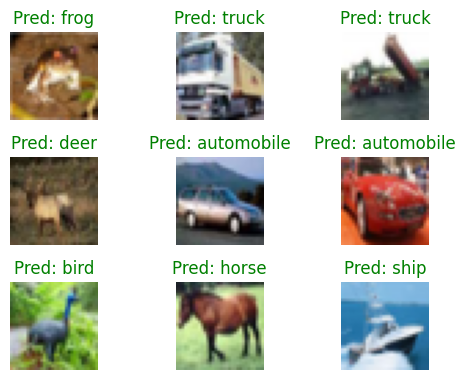

In [10]:
# plot natural images
output = model_noattack(imgs)
plot_images(imgs, labels, output, 3, 3)

#### **Adversarial Training**

1. FGSM

In [ ]:
print('Model with attack FGSM:')
# adverserial training with PGD
model_withattackFGSM = ConvModel()
if cuda:
  model_withattack = model_withattackFGSM.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_withattackFGSM.parameters(), lr=0.01)
#define attack
eps = 0.1
fgsm = FastGradientSignMethod(model_withattackFGSM, eps)
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 20

train_losses = adversarial_train_model(model_withattackFGSM, criterion, opt, train_loader, epochs, attack=fgsm, perc_attacked=perc_attacked, verbose=True)

Model with attack FGSM:
Epoch: 1 	Training Loss: 2.006912
Epoch: 2 	Training Loss: 1.497707
Epoch: 3 	Training Loss: 1.013749
Epoch: 4 	Training Loss: 0.577592
Epoch: 5 	Training Loss: 0.263278
Epoch: 6 	Training Loss: 0.337313
Epoch: 7 	Training Loss: 0.481598
Epoch: 8 	Training Loss: 0.254311
Epoch: 9 	Training Loss: 0.368725
Epoch: 10 	Training Loss: 0.290066
Epoch: 11 	Training Loss: 0.176220
Epoch: 12 	Training Loss: 0.132056
Epoch: 13 	Training Loss: 0.104240
Epoch: 14 	Training Loss: 0.111659
Epoch: 15 	Training Loss: 0.182688
Epoch: 16 	Training Loss: 0.269929
Epoch: 17 	Training Loss: 0.069440
Epoch: 18 	Training Loss: 0.168242
Epoch: 19 	Training Loss: 0.406861
Epoch: 20 	Training Loss: 0.308254


Classification non attacked img of a standard training


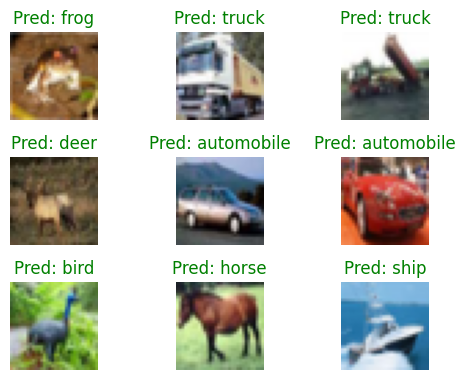

Classification with attacked img of a standard training


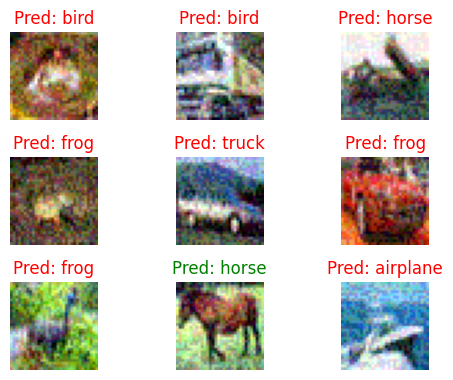

Classification with attacked img of an adversarial training


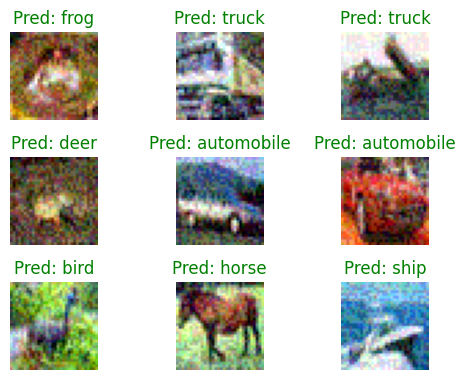

In [ ]:
# plot natural images
delta = fgsm.compute(imgs, labels)
print("Classification non attacked img of a standard training")
plot_images(imgs, labels, model_noattack(imgs),M=3, N=3)
print("Classification with attacked img of a standard training")
plot_images(imgs+delta, labels, model_noattack(imgs+delta), M=3, N=3)
print("Classification with attacked img of an adversarial training")
plot_images(imgs+delta, labels, model_withattackFGSM(imgs+delta), M=3, N=3)

2. PGB L0

When using PGD for adversarial training, it's normal for the model to struggle with convergence compared to FGSM or standard training. This is because PGD generates stronger, more challenging adversarial examples through iterative optimization, making the training harder. PGD requires more careful tuning of hyperparameters like learning rate and attack step size. To help, consider adjusting the learning rate, experimenting with different PGD parameters, or using a mix of FGSM and PGD in the early stages of training.

In [21]:
print('Model with attack PGD L0:')
# adverserial training with PGD
model_withattackPGD = ConvModel()
if cuda:
  model_withattackPGD = model_withattackPGD.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_withattackPGD.parameters(), lr=0.001)
#define attack
pdg_l0 = ProjectedGradientDescent(model_withattackPGD, eps=0.03, alpha=0.006, num_iter=10)
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 20

train_losses = adversarial_train_model(model_withattackPGD, criterion, opt, train_loader, epochs, attack=pdg_l0, perc_attacked=perc_attacked, verbose=True)

Model with attack PGD L0:
Epoch: 1 	Training Loss: 1.948103
Epoch: 2 	Training Loss: 1.932505
Epoch: 3 	Training Loss: 1.912804
Epoch: 4 	Training Loss: 2.133803
Epoch: 5 	Training Loss: 1.866605
Epoch: 6 	Training Loss: 1.772192
Epoch: 7 	Training Loss: 1.716593
Epoch: 8 	Training Loss: 1.778008
Epoch: 9 	Training Loss: 1.779286
Epoch: 10 	Training Loss: 1.740553
Epoch: 11 	Training Loss: 1.660938
Epoch: 12 	Training Loss: 1.834759
Epoch: 13 	Training Loss: 1.892567
Epoch: 14 	Training Loss: 1.684226
Epoch: 15 	Training Loss: 1.703800
Epoch: 16 	Training Loss: 1.807644
Epoch: 17 	Training Loss: 1.708062
Epoch: 18 	Training Loss: 1.854463
Epoch: 19 	Training Loss: 1.717692
Epoch: 20 	Training Loss: 1.752355


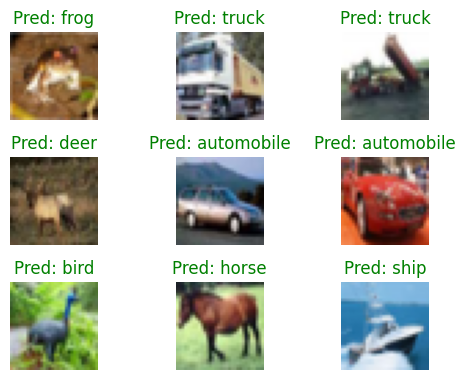

Classification with attacked img of a standard training


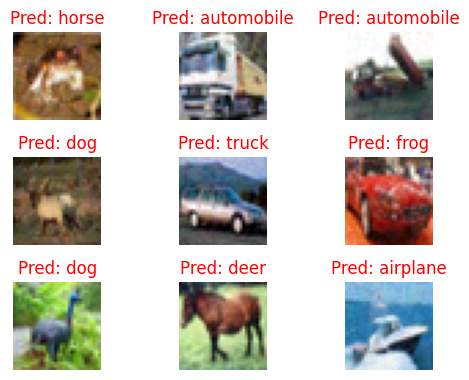

Classification with attacked img of an adversarial training


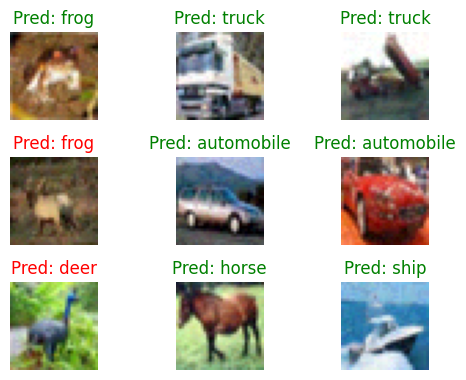

In [38]:
pgd = ProjectedGradientDescent(model_noattack, 0.03, 0.006, 20)
# plot natural images
delta = pgd.compute(imgs, labels)
#print("Classification non attacked img of a standard training")
plot_images(imgs, labels, model_noattack(imgs),M=3, N=3)
print("Classification with attacked img of a standard training")
plot_images(imgs+delta, labels, model_noattack(imgs+delta), M=3, N=3)
print("Classification with attacked img of an adversarial training")
plot_images(imgs+delta, labels, model_withattackPGD(imgs+delta), M=3, N=3)

3. PGD L2

In [ ]:
print('Model with attack PGD L2:')
# adverserial training with PGD
model_withattackPGDL2 = ConvModel()
if cuda:
  model_withattack = model_withattackPGDL2.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_withattackPGDL2.parameters(), lr=0.001)
#define attack
eps = 0.1
pdg_l2 = ProjectedGradientDescent(model_withattackPGDL2, 0.1, 0.001, 2)
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 5

train_losses = adversarial_train_model(model_withattackPGDL2, criterion, opt, train_loader, epochs, attack=pdg_l2, perc_attacked=perc_attacked, verbose=True)

Model with attack PGD L2:
Epoch: 1 	Training Loss: 1.372156
Epoch: 2 	Training Loss: 1.281798
Epoch: 3 	Training Loss: 1.194507
Epoch: 4 	Training Loss: 0.938201
Epoch: 5 	Training Loss: 1.144774


4. PGD Linf


In [ ]:
print('Model with attack PGD Linf:')
# adverserial training with PGD
model_withattackPGDLinf = ConvModel()
if cuda:
  model_withattack = model_withattackPGDLinf.cuda()
# define your loss
criterion = nn.CrossEntropyLoss()
# define the optimizer
opt = optim.Adam(model_withattackPGDLinf.parameters(), lr=0.001)
#define attack
eps = 0.1
pdg_linf = ProjectedGradientDescent(model_withattackPGDLinf, 0.1, 0.001, 2)
#define % attacked of the train dataset
perc_attacked = 1
# define epoch
epochs = 5

train_losses = adversarial_train_model(model_withattackPGDLinf, criterion, opt, train_loader, epochs, attack=pdg_linf, perc_attacked=perc_attacked, verbose=True)

Model with attack PGD Linf:
Epoch: 1 	Training Loss: 1.389466
Epoch: 2 	Training Loss: 1.487089
Epoch: 3 	Training Loss: 1.142921
Epoch: 4 	Training Loss: 1.002026
Epoch: 5 	Training Loss: 1.148413


### B. Evaluating Robustness vs. Accuracy Tradeoff

**Metrics to Consider**

In [ ]:
def eval_model(model, loader, attack=None, attack_name=''):
  """Function to evaluate your model on a specific loader"""
  accuracy = 0.
  n_inputs = 0.
  for n_batch, (imgs, labels) in enumerate(loader):
    if cuda:
      imgs, labels = imgs.cuda(), labels.cuda()
    if attack is None:
      outputs = model(imgs)
    else:
      delta = attack.compute(imgs, labels)
      adv = imgs + delta
      outputs = model(adv)
    _, predicted = torch.max(outputs.data, 1)
    accuracy += predicted.eq(labels.data).cpu().sum().numpy()
    n_inputs += imgs.shape[0]
  accuracy /= n_inputs

  if attack is None:
    print('Clean Accuracy, accuracy on testset: {:.4f}'.format(accuracy))
  else:
    print('Robust Accuracy, accuracy on testset with attack {}: {:.4f}'.format(attack_name, accuracy))


**Tradeoff Insights**

1. On model without adversarial training

In [ ]:
#Clean Accuracy: eval model on not attacked test set
eval_model(model_noattack, test_loader)
#Robust Accuracy: eval model attacked test set
eval_model(model_noattack, test_loader, fgsm, 'FGSM')
eval_model(model_noattack, test_loader, pdg_l0, 'PGD L0')
eval_model(model_noattack, test_loader, pdg_l2, 'PGD L2')
eval_model(model_noattack, test_loader, pdg_linf, 'PGD Linf')

Clean Accuracy, accuracy on testset: 0.7300
Robust Accuracy, accuracy on testset with attack FGSM: 0.0992
Robust Accuracy, accuracy on testset with attack PGD L0: 0.6977
Robust Accuracy, accuracy on testset with attack PGD L2: 0.6972
Robust Accuracy, accuracy on testset with attack PGD Linf: 0.6974


2. On model with adversarial dedicated adversarial training

In [ ]:
#Clean Accuracy: eval model on not attacked test set
eval_model(model_withattackFGSM, test_loader)
eval_model(model_withattackPGD, test_loader)
eval_model(model_withattackPGDL2, test_loader)
eval_model(model_withattackPGDLinf, test_loader)

#Robust Accuracy: eval model attacked test set
eval_model(model_withattackFGSM, test_loader, fgsm, 'FGSM')
eval_model(model_withattackPGD, test_loader, pdg_l0, 'PGD L0')
eval_model(model_withattackPGDL2, test_loader, pdg_l2, 'PGD L2')
eval_model(model_withattackPGDLinf, test_loader, pdg_linf, 'PGD Linf')

Clean Accuracy, accuracy on testset: 0.6012
Clean Accuracy, accuracy on testset: 0.7306
Clean Accuracy, accuracy on testset: 0.7221
Clean Accuracy, accuracy on testset: 0.7102
Robust Accuracy, accuracy on testset with attack FGSM: 0.8686
Robust Accuracy, accuracy on testset with attack PGD L0: 0.6638
Robust Accuracy, accuracy on testset with attack PGD L2: 0.6500
Robust Accuracy, accuracy on testset with attack PGD Linf: 0.6433
